## Creating the training dataset from the equilibria dataset

In [12]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU
import numpy as np
from scipy.io import loadmat, savemat
from time import time
from os.path import join, exists
from utils import *
from tqdm import tqdm
print("Preparing data...")

Preparing data...


In [13]:
# hyperparameters
# HAS_SCREEN = True # prototypying
HAS_SCREEN = False # for cluster
DTYPE = 'float32'
# TAR_GZ_FILE = 'dss/ds1.tar.gz' # the tar.gz file containing the data
# TAR_GZ_FILE = 'dss/ds3.tar.gz' # the tar.gz file containing the data
TAR_GZ_FILE = 'dss/ds5.tar.gz' # the tar.gz file containing the data
TMP_DIR = 'dss/tmp' # where the data will be stored
DATA_DIR = 'dss/ds' # where the data will be stored

# hyperparameters
N_SAMPLES = 200_000 #100_000 # number of samples to use for training
TRAIN_EVAL_SPLIT = 0.8 # percentage of the dataset to use for training
FULL_SUBGRID_SPLIT = 0.0 #0.25 # percentage of the full grid 
assert FULL_SUBGRID_SPLIT == 0.0, "Full subgrid split must be zero"

In [ ]:
# extract the tar.gz file into the tmp directory
if exists(TMP_DIR):
    print(f"Removing {TMP_DIR}...")
    os.system(f"rm -rf {TMP_DIR}")
os.mkdir(TMP_DIR)
os.makedirs(DATA_DIR, exist_ok=True)
print(f"Extracting {TAR_GZ_FILE} into {TMP_DIR}...")
os.system(f"tar -xzf {TAR_GZ_FILE} -C {TMP_DIR}")
print(f"Extracted {TAR_GZ_FILE} into {TMP_DIR}.")

In [15]:
# read the grid coordinates
d = loadmat('tcv_params/grid.mat')
RD, ZD = d['r'].flatten(), d['z'].flatten() # original grid coordinates (DATA)
r0, r1 = RD[0], RD[-1]  # min and max r
z0, z1 = ZD[0], ZD[-1]  # min and max z
r,z = np.linspace(r0, r1, N_GRID_R), np.linspace(z0, z1, N_GRID_Z)  # grid coordinates

RRD, ZZD = np.meshgrid(RD, ZD)  # meshgrid for the original grid coordinates (from the data)
print(f'RRD shape: {RRD.shape}, ZZD shape: {ZZD.shape}')

RRD shape: (65, 28), ZZD shape: (65, 28)


In [ ]:
# load the data
print("Loading data...")

# list all the files inside TMP_DIR/ds
files = sorted([f for f in os.listdir(f'{TMP_DIR}/ds') if f.endswith('.mat')])
print(f'Found {len(files)} files.')
Fxs, Iys, Ias, Bms, Ufs = [], [], [], [], []
files_iter = tqdm(files, desc="Loading files", unit="file") if HAS_SCREEN else files
# files_iter = files
for f in files_iter:
    try:
    # if True:
        d = loadmat(join(TMP_DIR, 'ds', f))
        # print(f'file: {f}, keys: {d.keys()}') #  'Bm', 'Fx', 'Ia', 'Ip', 'Iy', 'Uf', 't'
        t, Ip = d['t'].flatten(), d['Ip'].flatten()  # time and plasma current
        sip = np.sign(np.mean(Ip)) # sign of the plasma current
        Fx = d['Fx']  # flux map
        Iy = d['Iy']  # current density map
        Ia = d['Ia']  # coil currents
        Bm = d['Bm']  # magnetic probe measurements
        Uf = d['Uf']  # flux loop poloidal flux

        nt = t.shape[0]  # number of time points
        assert Fx.shape == (28, 65, nt), f'Fx shape mismatch: {Fx.shape} != (28, 65, {nt})'
        assert Iy.shape == (28, 65, nt), f'Iy shape mismatch: {Iy.shape} != (28, 65, {nt})'
        assert Ia.shape == (19, nt), f'Ia shape mismatch: {Ia.shape} != (19, {nt})'
        assert Bm.shape == (38, nt), f'Bm shape mismatch: {Bm.shape} != (38, {nt})'
        assert Uf.shape == (38, nt), f'Uf shape mismatch: {Uf.shape} != (38, {nt})'

        # check none of the values are NaN
        assert not np.isnan(Fx).any(), f'Fx contains NaN values: {f}'
        assert not np.isnan(Iy).any(), f'Iy contains NaN values: {f}'
        assert not np.isnan(Ia).any(), f'Ia contains NaN values: {f}'
        assert not np.isnan(Bm).any(), f'Bm contains NaN values: {f}'
        assert not np.isnan(Uf).any(), f'Uf contains NaN values: {f}'
        # check the values are finite
        assert np.isfinite(Fx).all(), f'Fx contains infinite values: {f}'
        assert np.isfinite(Iy).all(), f'Iy contains infinite values: {f}'
        assert np.isfinite(Ia).all(), f'Ia contains infinite values: {f}'
        assert np.isfinite(Bm).all(), f'Bm contains infinite values: {f}'
        assert np.isfinite(Uf).all(), f'Uf contains infinite values: {f}'
    
        Fxs.append(Fx), Iys.append(Iy), Ias.append(Ia), Bms.append(Bm), Ufs.append(Uf)
    
    except Exception as e:
        print(f'Error loading {f}: {e}')
        continue

print(f'Loaded {len(Fxs)} files.')
assert len(Fxs) > 0, f'No samples: {len(Fxs)}'

# convert to numpy arrays
Fx = np.concatenate(Fxs, axis=-1).astype(DTYPE).transpose(2,1,0)  # flux map
Iy = np.concatenate(Iys, axis=-1).astype(DTYPE).transpose(2,1,0)  # current density map
Ia = np.concatenate(Ias, axis=-1).astype(DTYPE).transpose(1,0)  # coil currents
Bm = np.concatenate(Bms, axis=-1).astype(DTYPE).transpose(1,0)  # magnetic probe measurements
Uf = np.concatenate(Ufs, axis=-1).astype(DTYPE).transpose(1,0)  # flux loop poloidal flux

assert Fx.shape[0] > 0, f'No samples: {Fx.shape}'

N = Fx.shape[0]  # number of samples
print(f'Loaded {N} samples.')

# assign to standard values
X = [Ia, Bm, Uf]  # inputs
Y = Fx # outputs
RHS = Iy  # right hand side

# remove the tmp directory
print(f"Removing {TMP_DIR}...")
os.system(f"rm -rf {TMP_DIR}")
print("Data loaded.")

# check the shapes
print(f'Fx shape: {Fx.shape}, Iy shape: {Iy.shape}, Ia shape: {Ia.shape}, Bm shape: {Bm.shape}, Uf shape: {Uf.shape}')
    
# print sizes in MB
print(f'Fx size: {Fx.nbytes / 1024**2:.2f} MB, Iy size: {Iy.nbytes / 1024**2:.2f} MB, Ia size: {Ia.nbytes / 1024**2:.2f} MB, Bm size: {Bm.nbytes / 1024**2:.2f} MB, Uf size: {Uf.nbytes / 1024**2:.2f} MB')
    

Loading data...


FileNotFoundError: [Errno 2] No such file or directory: 'dss/tmp/ds'

TypeError: Shapes of x (65, 28) and z (28, 65) do not match

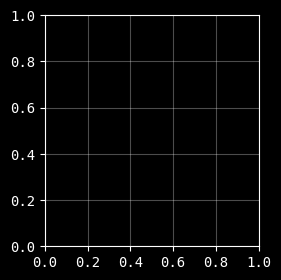

In [ ]:
# plot some examples
n_plot = 3
rand_idxs = np.random.randint(0, N, n_plot)
for i, ri in enumerate(rand_idxs):
    plt.figure(figsize=(16, 3))
    plt.subplot(1, 5, 1)
    plt.contourf(RRD, ZZD, Fx[ri], levels=20)
    plt.axis('equal'), plt.axis('off')
    plt.title('Fx')
    plt.colorbar()
    plt.subplot(1, 5, 2)
    plt.contourf(RRD, ZZD, Iy[ri], levels=20)
    plt.axis('equal'), plt.axis('off')
    plt.title('Iy')
    plt.colorbar()
    plt.subplot(1, 5, 3)
    plt.bar(np.arange(Ia.shape[1]), Ia[ri])
    plt.title('Ia')
    plt.subplot(1, 5, 4)
    plt.bar(np.arange(Bm.shape[1]), Bm[ri])
    plt.title('Bm')
    plt.subplot(1, 5, 5)
    plt.bar(np.arange(Uf.shape[1]), Uf[ri])
    plt.title('Uf')
    plt.tight_layout()
    plt.suptitle(f'SHOT {ri}')
    plt.show() if HAS_SCREEN else plt.savefig(f'{DATA_DIR}/example_{i}.png')

In [ ]:
# test interpolation
idx = np.random.randint(0, N)
f, rhs = Fx[idx,:,:], Iy[idx,:,:]
rrg, zzg = sample_random_subgrid(RRD,ZZD, N_GRID_Z, N_GRID_R)
print(f.shape, rhs.shape, rrg.shape, zzg.shape)
box = get_box_from_grid(rrg, zzg)
f_grid = interp_fun(Fx[idx,:,:], RRD, ZZD, rrg, zzg)
rhs_grid = interp_fun(rhs, RRD, ZZD, rrg, zzg)

fig,ax = plt.subplots(1,5, figsize=(20,5))
ax[0].scatter(RRD, ZZD, marker='.')
ax[0].scatter(rrg, zzg, marker='.')
ax[0].set_aspect('equal')

im1 = ax[1].contourf(RRD, ZZD, f, 20)
ax[1].plot(box[:,0],box[:,1])
ax[1].set_aspect('equal')

im2 = ax[2].contourf(rrg, zzg, f_grid, 20)
ax[2].set_aspect('equal')

im3 = ax[3].contourf(RRD, ZZD, rhs, 20)
ax[3].set_aspect('equal')
ax[3].plot(box[:,0],box[:,1])

im4 = ax[4].contourf(rrg, zzg, rhs_grid, 20)
ax[4].set_aspect('equal')

plt.colorbar(im1,ax=ax[1])
plt.colorbar(im2,ax=ax[2])
plt.colorbar(im3,ax=ax[3])
plt.colorbar(im4,ax=ax[4])

plt.show() if HAS_SCREEN else plt.savefig(join(DATA_DIR, 'interpolation_example.png'))

plt.figure(figsize=(5,10))
rrg = rrg.reshape(-1)
zzg = zzg.reshape(-1)
plt.plot(rrg, zzg)
plt.scatter(rrg, zzg, c=np.linspace(0,1,N_GRID_R*N_GRID_Z), cmap='inferno')
plt.scatter(rrg[0], zzg[0], c='r', marker='o')
plt.scatter(rrg[-1], zzg[-1], c='b', marker='o')
plt.axis('equal')
plt.title('Subgrid')
plt.show() if HAS_SCREEN else plt.savefig(join(DATA_DIR, 'subgrid_example.png'))

In [ ]:
# dataset splitting (N_TOP = original dataset size)
NT = int(N_SAMPLES*TRAIN_EVAL_SPLIT)    # training
NE = N_SAMPLES - NT                     # evaluation
NTF = int(NT*FULL_SUBGRID_SPLIT)        # training full
NTS = NT - NTF                          # training subgrid
NEF = int(NE*FULL_SUBGRID_SPLIT)        # evaluation full
NES = NE - NEF                          # evaluation subgrid 
assert NTF+NTS == NT
assert NEF+NES == NE
assert NTF + NTS + NEF + NES == N_SAMPLES
print(f"Training: {NT}, full: {NTF}, subgrid: {NTS}")
print(f"Eval:     {NE}, full: {NEF}, subgrid: {NES}")
orig_idxs = np.random.permutation(N)
orig_idxs_train = orig_idxs[:int(N*TRAIN_EVAL_SPLIT)] # original indices for training
orig_idxs_eval = orig_idxs[int(N*TRAIN_EVAL_SPLIT):] # original indices for evaluation
# splitting the idxs
assert len(orig_idxs_train) > NTF, f"Training set is too small, {len(orig_idxs_train)} < {NTF}"
idxs_tf = np.random.choice(orig_idxs_train, NTF, replace=False) # training full
assert len(orig_idxs_train) > NTS, f"Training set is too small, {len(orig_idxs_train)} < {NTS}"
idxs_ts = np.random.choice(orig_idxs_train, NTS, replace=False) # can overlap with idxs_tf
assert len(orig_idxs_eval) > NEF, f"Evaluation set is too small, {len(orig_idxs_eval)} < {NEF}"
idxs_ef = np.random.choice(orig_idxs_eval, NEF, replace=False) # evaluation full
assert len(orig_idxs_eval) > NES, f"Evaluation set is too small, {len(orig_idxs_eval)} < {NES}"
idxs_es = np.random.choice(orig_idxs_eval, NES, replace=False) # can overlap with idxs_ef

In [ ]:
# create arrays to store the dataset
# x_tf = [np.zeros((NTF, *x[0].shape), dtype=DTYPE) for x in X]
# y_tf = np.zeros((NTF, N_GRID_Z, N_GRID_R), dtype=DTYPE)
# rr_tf = np.zeros((NTF, N_GRID_Z, N_GRID_R), dtype=DTYPE)
# zz_tf = np.zeros((NTF, N_GRID_Z, N_GRID_R), dtype=DTYPE)
# rhs_tf = np.zeros((NTF, N_GRID_Z, N_GRID_R), dtype=DTYPE)

x_ts = [np.zeros((NTS, *x[0].shape), dtype=DTYPE) for x in X]
y_ts = np.zeros((NTS, N_GRID_Z, N_GRID_R), dtype=DTYPE)
rr_ts = np.zeros((NTS, N_GRID_Z, N_GRID_R), dtype=DTYPE)
zz_ts = np.zeros((NTS, N_GRID_Z, N_GRID_R), dtype=DTYPE)
rhs_ts = np.zeros((NTS, N_GRID_Z, N_GRID_R), dtype=DTYPE)

# x_ef = [np.zeros((NEF, *x[0].shape), dtype=DTYPE) for x in X]
# y_ef = np.zeros((NEF, N_GRID_Z, N_GRID_R), dtype=DTYPE)
# rr_ef = np.zeros((NEF, N_GRID_Z, N_GRID_R), dtype=DTYPE)
# zz_ef = np.zeros((NEF, N_GRID_Z, N_GRID_R), dtype=DTYPE)
# rhs_ef = np.zeros((NEF, N_GRID_Z, N_GRID_R), dtype=DTYPE)

x_es = [np.zeros((NES, *x[0].shape), dtype=DTYPE) for x in X]
y_es = np.zeros((NES, N_GRID_Z, N_GRID_R), dtype=DTYPE)
rr_es = np.zeros((NES, N_GRID_Z, N_GRID_R), dtype=DTYPE)
zz_es = np.zeros((NES, N_GRID_Z, N_GRID_R), dtype=DTYPE)
rhs_es = np.zeros((NES, N_GRID_Z, N_GRID_R), dtype=DTYPE)

## fill the arrays
# # Train Full -> just copy the data
# for ix, x in enumerate(X): x_tf[ix][:] = x[idxs_tf]
# y_tf[:], rhs_tf[:] = Y[idxs_tf], RHS[idxs_tf]
# rr_tf[:], zz_tf[:] = RRD, ZZD
# Train Subgrid -> interpolate the data
for ix, x in enumerate(X): x_ts[ix][:] = x[idxs_ts]
start_time = time()
for i, idx in enumerate(idxs_ts):
    (yi, rhsi), rri, zzi = resample_on_new_subgrid([Y[idx], RHS[idx]], RRD, ZZD, N_GRID_Z, N_GRID_R)
    y_ts[i], rhs_ts[i], rr_ts[i], zz_ts[i] = yi, rhsi, rri, zzi
    if (i+1) % 1000 == 0: print(f"Train Subgrid: {i+1}/{NTS}, eta: {((time()-start_time)/(i+1)*(NTS-i-1))/60:.1f} min", flush=True)
# # Eval Full -> just copy the data
# for ix, x in enumerate(X): x_ef[ix][:] = x[idxs_ef]
# y_ef[:], rhs_ef[:] = Y[idxs_ef], RHS[idxs_ef]
# rr_ef[:], zz_ef[:] = RRD, ZZD
# Eval Subgrid -> interpolate the data
for ix, x in enumerate(X): x_es[ix][:] = x[idxs_es]
start_time = time()
for i, idx in enumerate(idxs_es):
    (yi, rhsi), rri, zzi = resample_on_new_subgrid([Y[idx], RHS[idx]], RRD, ZZD, N_GRID_Z, N_GRID_R)
    y_es[i], rhs_es[i], rr_es[i], zz_es[i] = yi, rhsi, rri, zzi
    if (i+1) % 1000 == 0: print(f"Eval Subgrid: {i+1}/{NES}, eta: {((time()-start_time)/(i+1)*(NES-i-1))/60:.1f} min", flush=True)

# concatenate the arrays
X_train = x_ts
y_train = y_ts
rr_train = rr_ts
zz_train = zz_ts
rhs_train = rhs_ts
del x_ts, y_ts, rr_ts, zz_ts, rhs_ts

X_eval = x_es
y_eval = y_es
rr_eval = rr_es
zz_eval = zz_es
rhs_eval = rhs_es
del x_es, y_es, rr_es, zz_es, rhs_es
print(f"x_train: [{[x.shape for x in X_train]}], y_train: {y_train.shape}, rr_train: {rr_train.shape}, zz_train: {zz_train.shape}, rhs_train: {rhs_train.shape}")
print(f"x_eval: [{[x.shape for x in X_eval]}], y_eval: {y_eval.shape}, rr_eval: {rr_eval.shape}, zz_eval: {zz_eval.shape}, rhs_eval: {rhs_eval.shape}")


In [ ]:
# calculate kernels for Grad-Shafranov equation
# so we don't have to do it during training
laplace_ker_t = np.zeros((len(X_train[0]), 3, 3), dtype=DTYPE)
laplace_ker_e = np.zeros((len(X_eval[0]), 3, 3), dtype=DTYPE)
df_dr_ker_t = np.zeros((len(X_train[0]), 3, 3), dtype=DTYPE)
df_dr_ker_e = np.zeros((len(X_eval[0]), 3, 3), dtype=DTYPE)
hrs_t, hzs_t = rr_train[:,1,2]-rr_train[:,1,1], zz_train[:,2,1]-zz_train[:,1,1]
hrs_e, hzs_e = rr_eval[:,1,2]-rr_eval[:,1,1], zz_eval[:,2,1]-zz_eval[:,1,1]
for i in range(len(X_train[0])):
    try:
        laplace_ker_t[i,:,:], df_dr_ker_t[i,:,:] = calc_laplace_df_dr_ker(hrs_t[i], hzs_t[i])
    except Exception as e:
        print(f"Error calculating laplace_ker_t for index {i}: {e}")
        # plot rr_train[i], zz_train[i]
        plt.figure()
        plt.scatter(rr_train[i], zz_train[i], marker='.')
        plt.title(f"rr_train[{i}]")
        plt.axis('equal')
        plt.show() if HAS_SCREEN else plt.savefig(f'{DATA_DIR}/rr_train_{i}.png')
        # plot rr_eval[i], zz_eval[i]
        break

for i in range(len(X_eval[0])):
    laplace_ker_e[i,:,:], df_dr_ker_e[i,:,:] = calc_laplace_df_dr_ker(hrs_e[i], hzs_e[i])

In [ ]:
# check the dataset
rows = 5
idxs_train = np.random.randint(0, len(X_train[0]), rows)
idxs_eval = np.random.randint(0, len(X_eval[0]), rows)
fig,ax = plt.subplots(rows,6, figsize=(15,3*rows))
box0 = get_box_from_grid(RRD, ZZD)
for i, (it, ie)  in enumerate(zip(idxs_train, idxs_eval)):
    # training
    boxi = get_box_from_grid(rr_train[it], zz_train[it])
    ax[i,0].plot(box0[:,0], box0[:,1])
    ax[i,0].plot(boxi[:,0], boxi[:,1])
    ax[i,0].set_aspect('equal')
    ax[i,0].set_title(f"Train {it}")
    a1 = ax[i,1].contourf(rr_train[it], zz_train[it], y_train[it], 20)
    ax[i,1].plot(box0[:,0], box0[:,1])
    ax[i,1].set_aspect('equal')
    plt.colorbar(a1,ax=ax[i,1])
    a2 = ax[i,2].contourf(rr_train[it], zz_train[it] ,-rhs_train[it], 20)
    ax[i,2].plot(box0[:,0], box0[:,1])
    ax[i,2].set_aspect('equal')
    plt.colorbar(a2,ax=ax[i,2])
    # evaluation
    boxi = get_box_from_grid(rr_eval[ie], zz_eval[ie])
    ax[i,3].plot(box0[:,0], box0[:,1])
    ax[i,3].plot(boxi[:,0], boxi[:,1])
    ax[i,3].set_aspect('equal')
    ax[i,3].set_title(f"Eval {ie}")
    a1 = ax[i,4].contourf(rr_eval[ie], zz_eval[ie], y_eval[ie], 20)
    ax[i,4].plot(box0[:,0], box0[:,1])
    ax[i,4].set_aspect('equal')
    plt.colorbar(a1,ax=ax[i,4])
    a2 = ax[i,5].contourf(rr_eval[ie], zz_eval[ie] ,-rhs_eval[ie], 20)
    ax[i,5].plot(box0[:,0], box0[:,1])
    ax[i,5].set_aspect('equal')
    plt.colorbar(a2,ax=ax[i,5])
plt.show() if HAS_SCREEN else plt.savefig(join(DATA_DIR, 'dataset_check.png'))

In [ ]:
from utils import calc_gso, calc_gso_batch
import torch
n_plots = 7
idxs = np.random.randint(0, len(X_train[0]), n_plots)
psis, rhss = y_train[idxs], rhs_train[idxs]
rrs, zzs = rr_train[idxs], zz_train[idxs]
big_box = get_box_from_grid(RRD, ZZD)
#batched version
psist = torch.tensor(psis, dtype=torch.float32).view(n_plots, 1, N_GRID_Z, N_GRID_R)
rrst = torch.tensor(rrs, dtype=torch.float32).view(n_plots, 1, N_GRID_Z, N_GRID_R)
zzst = torch.tensor(zzs, dtype=torch.float32).view(n_plots, 1, N_GRID_Z, N_GRID_R)
print(f'psi: {psist.shape}, rr: {rrst.shape}, zz: {zzst.shape}')
gsos = calc_gso_batch(psist, rrst, zzst)
print(f'gsos: {gsos.shape}')
gsos = gsos.view(n_plots, N_GRID_Z, N_GRID_R).numpy()
# single version
for i in range(n_plots):
    psi, rr, zz, rhs = psis[i], rrs[i], zzs[i], rhss[i]
    box = get_box_from_grid(rr, zz)
    gso = calc_gso(psi, rr, zz) # calculate the Grad-Shafranov operator
    gso2 = gsos[i]
    #plot error gso vs gso2
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    im = ax.contourf(rr, zz, np.abs(gso-gso2), 20)
    ax.plot(big_box[:,0], big_box[:,1])
    ax.set_aspect('equal')
    ax.set_title(f"Error batch/no batch {i}")
    plt.colorbar(im, ax=ax)
    plt.show() if HAS_SCREEN else plt.savefig(join(DATA_DIR, f'gso_error_{i}.png'))
    # NOTE: the error between the batched and non-batched version can be non-zero due to different
    # implementations in gpu
    print(f"max error batch/no batch: {np.abs(gso-gso2).max()}")
    # assert np.allclose(gso, gso2, rtol=1e-2), f"Error in the calculation of the Grad-Shafranov operator: \ngso:\n{gso}, \ngso2:\n{gso2}"
    # psi, gso, rhs = psi[1:-1,1:-1], gso[1:-1,1:-1], rhs[1:-1,1:-1]
    # rr, zz = rr[1:-1,1:-1], zz[1:-1,1:-1] 
    fig,ax = plt.subplots(1,5, figsize=(20,5))
    ax[0].plot(big_box[:,0], big_box[:,1])
    ax[0].plot(box[:,0], box[:,1])
    ax[0].set_aspect('equal')
    ax[0].set_xticks([]), ax[0].set_yticks([])
    ax[0].set_title(f"Train {idxs}")
    im1 = ax[1].contourf(rr, zz, psi, 20)
    ax[1].plot(big_box[:,0], big_box[:,1])
    ax[1].set_aspect('equal')
    ax[1].set_xticks([]), ax[1].set_yticks([])
    ax[1].set_title("Ψ")
    im2 = ax[2].contourf(rr, zz, -gso, 20)
    ax[2].plot(big_box[:,0], big_box[:,1])
    ax[2].set_aspect('equal')
    ax[2].set_xticks([]), ax[2].set_yticks([])
    ax[2].set_title("GSO recalculated")
    im3 = ax[3].contourf(rr, zz, -rhs, 20)
    ax[3].plot(big_box[:,0], big_box[:,1])
    ax[3].set_aspect('equal')
    ax[3].set_xticks([]), ax[3].set_yticks([])
    ax[3].set_title("GSO from dataset")
    im4 = ax[4].contourf(rr, zz, np.abs(gso-rhs), 20)
    ax[4].plot(big_box[:,0], big_box[:,1])
    ax[4].set_aspect('equal')
    ax[4].set_xticks([]), ax[4].set_yticks([])
    ax[4].set_title("Absolute error")
    plt.colorbar(im1,ax=ax[1])
    plt.colorbar(im2,ax=ax[2])
    plt.colorbar(im3,ax=ax[3])
    plt.colorbar(im4,ax=ax[4])
    plt.show() if HAS_SCREEN else plt.savefig(join(DATA_DIR, f'gso_check_{i}.png'))

In [ ]:
assert y_train.shape[1:] == (N_GRID_R, N_GRID_Z), f"X_train shape mismatch: {X_train[0].shape[1:]} != ({N_GRID_R}, {N_GRID_Z})"
assert y_eval.shape[1:] == (N_GRID_R, N_GRID_Z), f"X_eval shape mismatch: {X_eval[0].shape[1:]} != ({N_GRID_R}, {N_GRID_Z})"

In [ ]:
# load dataset anc calculate statistics
curr = X_train[0] # coil currents
mag = X_train[1] # magnetic probe measurements
prof = X_train[2] # flux loop poloidal flux


curr_mean_std = np.vstack([np.mean(curr, axis=0), np.std(curr, axis=0)])
mag_mean_std = np.vstack([np.mean(mag, axis=0), np.std(mag, axis=0)])
prof_mean_std = np.vstack([np.mean(prof, axis=0), np.std(prof, axis=0)])

print(f'curr_mean_std: {curr_mean_std.shape}, mag_mean_std: {mag_mean_std.shape}, prof_mean_std: {prof_mean_std.shape}')

In [ ]:
# save the datasets as mat files
train_ds_path = join(DATA_DIR, f'train_ds_{N_SAMPLES}_{TRAIN_EVAL_SPLIT*100:.0f}_{FULL_SUBGRID_SPLIT*100:.0f}.mat')
eval_ds_path = join(DATA_DIR, f'eval_ds_{N_SAMPLES}_{TRAIN_EVAL_SPLIT*100:.0f}_{FULL_SUBGRID_SPLIT*100:.0f}.mat')
savemat(train_ds_path, {
        'currs':curr, 
        'currs_mean_std':curr_mean_std,
        'magnetic':mag, 
        'magnetic_mean_std':mag_mean_std,
        'profiles':prof, 
        'profiles_mean_std':prof_mean_std,
        'psi':y_train, 
        'rr':rr_train, 
        'zz':zz_train,
        })
savemat(eval_ds_path, {
        'currs':X_eval[0],
        'currs_mean_std':curr_mean_std,
        'magnetic':X_eval[1], 
        'magnetic_mean_std':mag_mean_std,
        'profiles':X_eval[2], 
        'profiles_mean_std':prof_mean_std,
        'psi':y_eval, 
        'rr':rr_eval, 
        'zz':zz_eval
        })
print("Pytorch (.mat) dataset saved!")

In [ ]:
# remove this part
os.system(f'cp {train_ds_path} dss/train_ds.mat')
os.system(f'cp {eval_ds_path} dss/eval_ds.mat')